# Font type Recognition using CNN : Convolutional Neural Network


* <font size=4 color='green'>MSTC seminar on Deep Learning & Tensorflow</font>


In [1]:
! pip install --upgrade tqdm

Requirement already up-to-date: tqdm in c:\anaconda2\envs\tensorflow\lib\site-packages


In [2]:
import tensorflow as tf
import numpy as np
import math


try:
    from tqdm import tqdm, tqdm_notebook
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

### All the steps for preparing training/tresting data

* Data: 2790 36x36 images

In [3]:
# Set random seed
np.random.seed(0)

# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


### CNN graph definition

In [4]:
sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, image with one channel (gray)
x = tf.placeholder("float", [None, 36, 36])
# Note that -1 is for reshaping
#if our image was RBG (3 color channels) last dimension of shape should be 3
x_im = tf.reshape(x, [-1,36,36,1])
## Known labels
# None works during variable creation to be
# unspecified size
y_ = tf.placeholder("float", [None,5])

In [5]:
# Conv layer 1
num_filters = 4 #also known as kernels 
winx = 5
winy = 5

W1 = tf.Variable(tf.truncated_normal(
    [winx, winy, 1 , num_filters],
    stddev=1./math.sqrt(winx*winy)))
b1 = tf.Variable(tf.constant(0.1,
                shape=[num_filters]))

# 5x5 convolution, pad with zeros on edges
xw = tf.nn.conv2d(x_im, W1,
                  strides=[1, 1, 1, 1],
                  padding='SAME')
h1 = tf.nn.relu(xw + b1)

# 2x2 Max pooling, no padding on edges
p1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='VALID')

# Need to flatten convolutional output for use in dense layer
p1_size = np.product(
          [s.value for s in p1.get_shape()[1:]])
p1f = tf.reshape(p1, [-1, p1_size ])

# Dense layer
num_hidden = 32
W2 = tf.Variable(tf.truncated_normal(
     [p1_size, num_hidden],
     stddev=2./math.sqrt(p1_size)))
b2 = tf.Variable(tf.constant(0.2,
     shape=[num_hidden]))
h2 = tf.nn.relu(tf.matmul(p1f,W2) + b2)

# Output Layer
W3 = tf.Variable(tf.truncated_normal(
     [num_hidden, 5],
     stddev=1./math.sqrt(num_hidden)))
b3 = tf.Variable(tf.constant(0.1,shape=[5]))

keep_prob = tf.placeholder("float")
h2_drop = tf.nn.dropout(h2, keep_prob)


#sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())


# Define model
y = tf.matmul(h2_drop,W3) + b3

#we need probabilities to print the confusion matrix
preds=tf.nn.softmax(y)

### ... end model specification, begin training code

In [6]:
# Climb on cross-entropy
#cross_entropy = tf.reduce_mean(
#        tf.nn.softmax_cross_entropy_with_logits(
#        y + 1e-50, y_))

cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        logits = y + 1e-50, labels=y_))


# How we train
train_step = tf.train.GradientDescentOptimizer(
             0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),
                              tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(
           correct_prediction, "float"))

## Train...

In [ ]:
# Actually train
epochs = 1000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy
    if i % 10 == 0:  
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train,
            y_: onehot_train, keep_prob: 1.0})
        train_acc[i//10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={x: test,
            y_: onehot_test, keep_prob: 1.0})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train,
        y_: onehot_train, keep_prob: 0.75})

cnn_test_pred=sess.run(preds,feed_dict={x: test,
            y_: onehot_test, keep_prob: 1.0})
    
# Save the weights
#saver = tf.train.Saver()
#saver.save(sess, "convTest.ckpt")

#print('convTest saved!')

In [10]:
name='temp.npz'
np.savez_compressed(name, train_acc, test_acc)

print('train & test accuracy saved!')

train & test accuracy saved!


In [11]:
name='temp.npz'
data = np.load(name)

In [12]:
type(data)

numpy.lib.npyio.NpzFile

In [13]:
data.files

['arr_0', 'arr_1']

In [14]:
train_acc = data['arr_0']
test_acc = data['arr_1']

In [17]:
# Restore
#saver = tf.train.Saver()
#saver.restore(sess, "convTest.ckpt")

In [18]:
# Check accuracy on train set
A = accuracy.eval(feed_dict={x: train,
    y_: onehot_train, keep_prob: 1.0})

print('Training Accuracy= %s' % A)

Training Accuracy= 0.796097


In [19]:
# And now the validation set
A = accuracy.eval(feed_dict={x: test,
    y_: onehot_test, keep_prob: 1.0})
print('Test Accuracy= %s' % A)

Test Accuracy= 0.731183


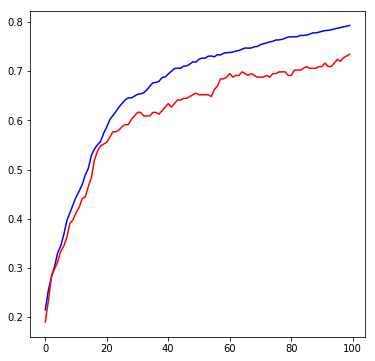

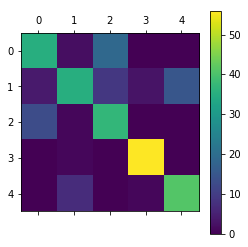

In [20]:
# Plot the accuracy curves

%matplotlib inline 
plt.figure(figsize=(6, 6))
plt.plot(train_acc,'b')
plt.plot(test_acc,'r')

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(
       feed_dict={x: test, keep_prob: 1.0,
       y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,
                              axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

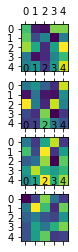

In [21]:
# Let's look at a subplot of some weights
f, plts = plt.subplots(4)
for i in range(4):
    plts[i].matshow(
            W1.eval()[:,:,0,i])

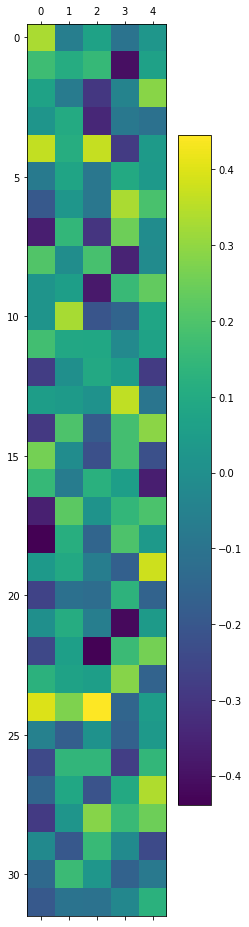

In [22]:
# Examine the output weights
plt.matshow(W3.eval())
plt.colorbar()

In [23]:
# Save the weights
saver = tf.train.Saver()
saver.save(sess, "conv1.ckpt")

ValueError: Parent directory of conv1.ckpt doesn't exist, can't save.

In [ ]:
# Restore
saver.restore(sess, "conv1.ckpt")

In [ ]:
# Or use Numpy manually
def save_all(name = 'conv1'):
    np.savez_compressed(name, W1.eval(),
            b1.eval(), W2.eval(), b2.eval(),
            W3.eval(), b3.eval())

save_all()

In [ ]:
def load_all(name = 'conv1.npz'):
    data = np.load(name)
    sess.run(W1.assign(data['arr_0']))
    sess.run(b1.assign(data['arr_1']))
    sess.run(W2.assign(data['arr_2']))
    sess.run(b2.assign(data['arr_3']))
    sess.run(W3.assign(data['arr_4']))
    sess.run(b3.assign(data['arr_5']))

load_all()

<h2>Confusion matrix</h2>

In [ ]:
#packages for confusion matrix
import itertools
import random
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.ticker as ticker
%matplotlib inline

In [ ]:
a=[]
b=[]

for i in cnn_test_pred:
    m=np.argmax(i)
    a.append(m)
    
for j in onehot_test:
    n=np.argmax(j)
    b.append(n)
    
    
prediction=np.asarray(a)
label=np.asarray(b)
    

In [ ]:
class_names=['0' ,'1' ,'2' ,'3','4'] 


#Definition of our plotting
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    
    """
    This function prints and plots the confusion matrix (cm).
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='horizontal')
    plt.yticks(tick_marks, classes)
    
    
#Set differences with and without normalization

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
  
 #some slight changes in order to plot % in the normalize confusion matrix
    if normalize:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, (("%.1f" % (cm[i,j]*100))),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        
    else:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(label, prediction)

#Setting print options. Float numbers precision of 2 for our output.
np.set_printoptions(precision=2) 

In [ ]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [ ]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix %')

plt.show()